In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib
import os


In [83]:

# Load data
train_data = pd.read_csv("train.csv")

# Display data info
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            188533 non-null  int64 
 1   brand         188533 non-null  object
 2   model         188533 non-null  object
 3   model_year    188533 non-null  int64 
 4   milage        188533 non-null  int64 
 5   fuel_type     183450 non-null  object
 6   engine        188533 non-null  object
 7   transmission  188533 non-null  object
 8   ext_col       188533 non-null  object
 9   int_col       188533 non-null  object
 10  accident      186081 non-null  object
 11  clean_title   167114 non-null  object
 12  price         188533 non-null  int64 
dtypes: int64(4), object(9)
memory usage: 18.7+ MB


Vi ser at det er en del "nulls" i fuel type men ikke for stor mengde. Så vi kunne ha droppet radene med "null" på fuel type.

In [27]:
#train_data = train_data.dropna(subset=['fuel_type'])

#train_data.info()

 Problemet er at "clean_title" har veldig mange "nulls". Vi ønsker ikke å fjerne alle de så vi forandrer det heller til "ukjent".

In [97]:
train_data['accident'] = train_data['accident'].fillna('Ingen rapportert')
train_data['clean_title'] = train_data['clean_title'].fillna('Ukjent')
train_data['int_col'] = train_data['int_col'].replace("–", "Ukjent")


Forandrer datatype fra object til "int64"

In [99]:
kategoriske_egenskaper = ["brand", "model", "fuel_type", "engine", "transmission", "accident", "clean_title", "int_col", "ext_col"]
for kol in kategoriske_egenskaper:
    train_data[kol], _ = pd.factorize(train_data[kol])

Vi ønsket å legge til "alder" og "kilometer_per_år". Her støttet vi på et problem ved at vi deler "milage" på "alder", så biler som hadde alder 0 skapte "null"-problemer. Vi valgte derfor å legge til "+1" på alle aldre på bilene, uten at vi tror det har stor påvirkning på modellen.

In [103]:
# Lag nye egenskaper: alder (+1 for å unngå 0-verdi) og kilometer_per_år
train_data['alder'] = (2024 - train_data['model_year']) + 1
train_data['kilometer_per_år'] = train_data['milage'] / train_data['alder']

#Fjern id-kolonnen til treningen
#train_data = train_data.drop(['id'], axis=1)
print(train_data.head())


   brand  model  model_year  milage  fuel_type  engine  transmission  ext_col  \
0      0      0        2007  213000          0       0             0        0   
1      1      1        2002  143250          0       1             0        1   
2      2      2        2002  136731          1       2             0        2   
3      3      3        2017   19500          0       3             1        3   
4      4      4        2021    7388          0       4             2        3   

   int_col  accident  clean_title  price  alder  kilometer_per_år  
0        0         0            0   4200     18      11833.333333  
1        1         1            0   4999     23       6228.260870  
2        0         0            0  13900     23       5944.826087  
3        2         0            0  45000      8       2437.500000  
4        1         0            0  97500      4       1847.000000  


array([[<Axes: title={'center': 'brand'}>,
        <Axes: title={'center': 'model'}>,
        <Axes: title={'center': 'model_year'}>,
        <Axes: title={'center': 'milage'}>],
       [<Axes: title={'center': 'fuel_type'}>,
        <Axes: title={'center': 'engine'}>,
        <Axes: title={'center': 'transmission'}>,
        <Axes: title={'center': 'ext_col'}>],
       [<Axes: title={'center': 'int_col'}>,
        <Axes: title={'center': 'accident'}>,
        <Axes: title={'center': 'clean_title'}>,
        <Axes: title={'center': 'price'}>],
       [<Axes: title={'center': 'alder'}>,
        <Axes: title={'center': 'kilometer_per_år'}>, <Axes: >, <Axes: >]],
      dtype=object)

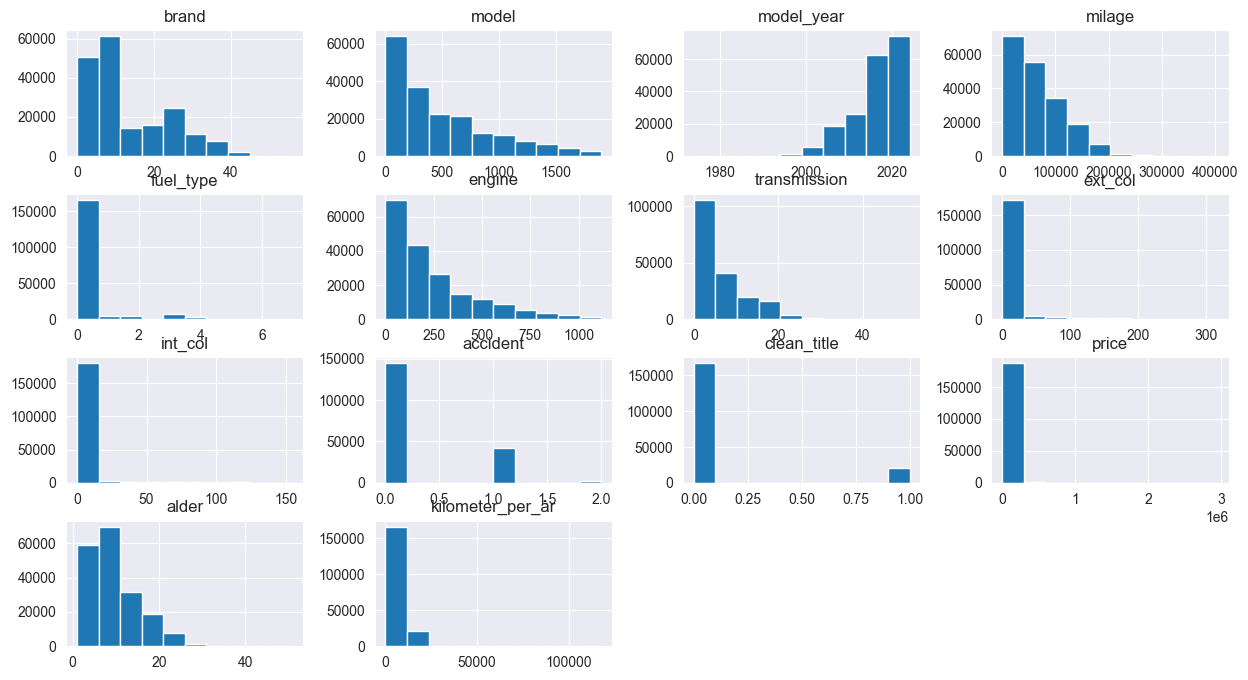

In [101]:
train_data.hist(figsize=(15, 8))

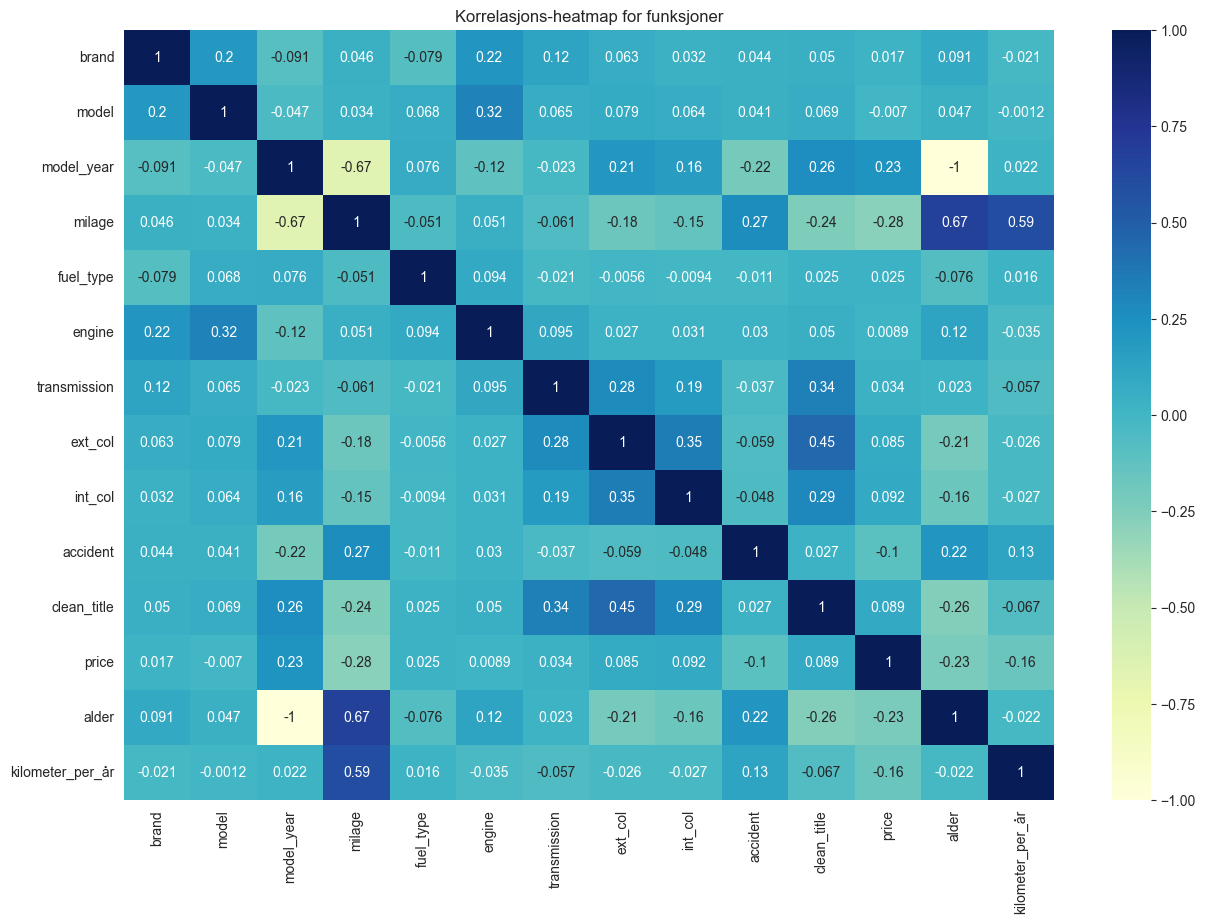

In [102]:
plt.figure(figsize=(15, 10))
sns.heatmap(train_data.corr(), annot=True, cmap="YlGnBu")
plt.title("Korrelasjons-heatmap for funksjoner")
plt.show()


Det første vi ser er en stor negativ korrelasjon mellom alder og model_year, som gir mening med tanke på hvordan vi har laget "alder". Det vi legger fokus på her er korrelasjonen mellom "price" og andre kategorier.

array([[<Axes: title={'center': 'brand'}>,
        <Axes: title={'center': 'model'}>,
        <Axes: title={'center': 'model_year'}>,
        <Axes: title={'center': 'fuel_type'}>],
       [<Axes: title={'center': 'transmission'}>,
        <Axes: title={'center': 'ext_col'}>,
        <Axes: title={'center': 'int_col'}>,
        <Axes: title={'center': 'accident'}>],
       [<Axes: title={'center': 'clean_title'}>,
        <Axes: title={'center': 'alder'}>,
        <Axes: title={'center': 'log_price'}>,
        <Axes: title={'center': 'log_milage'}>],
       [<Axes: title={'center': 'log_engine'}>,
        <Axes: title={'center': 'log_kilometer_per_år'}>, <Axes: >,
        <Axes: >]], dtype=object)

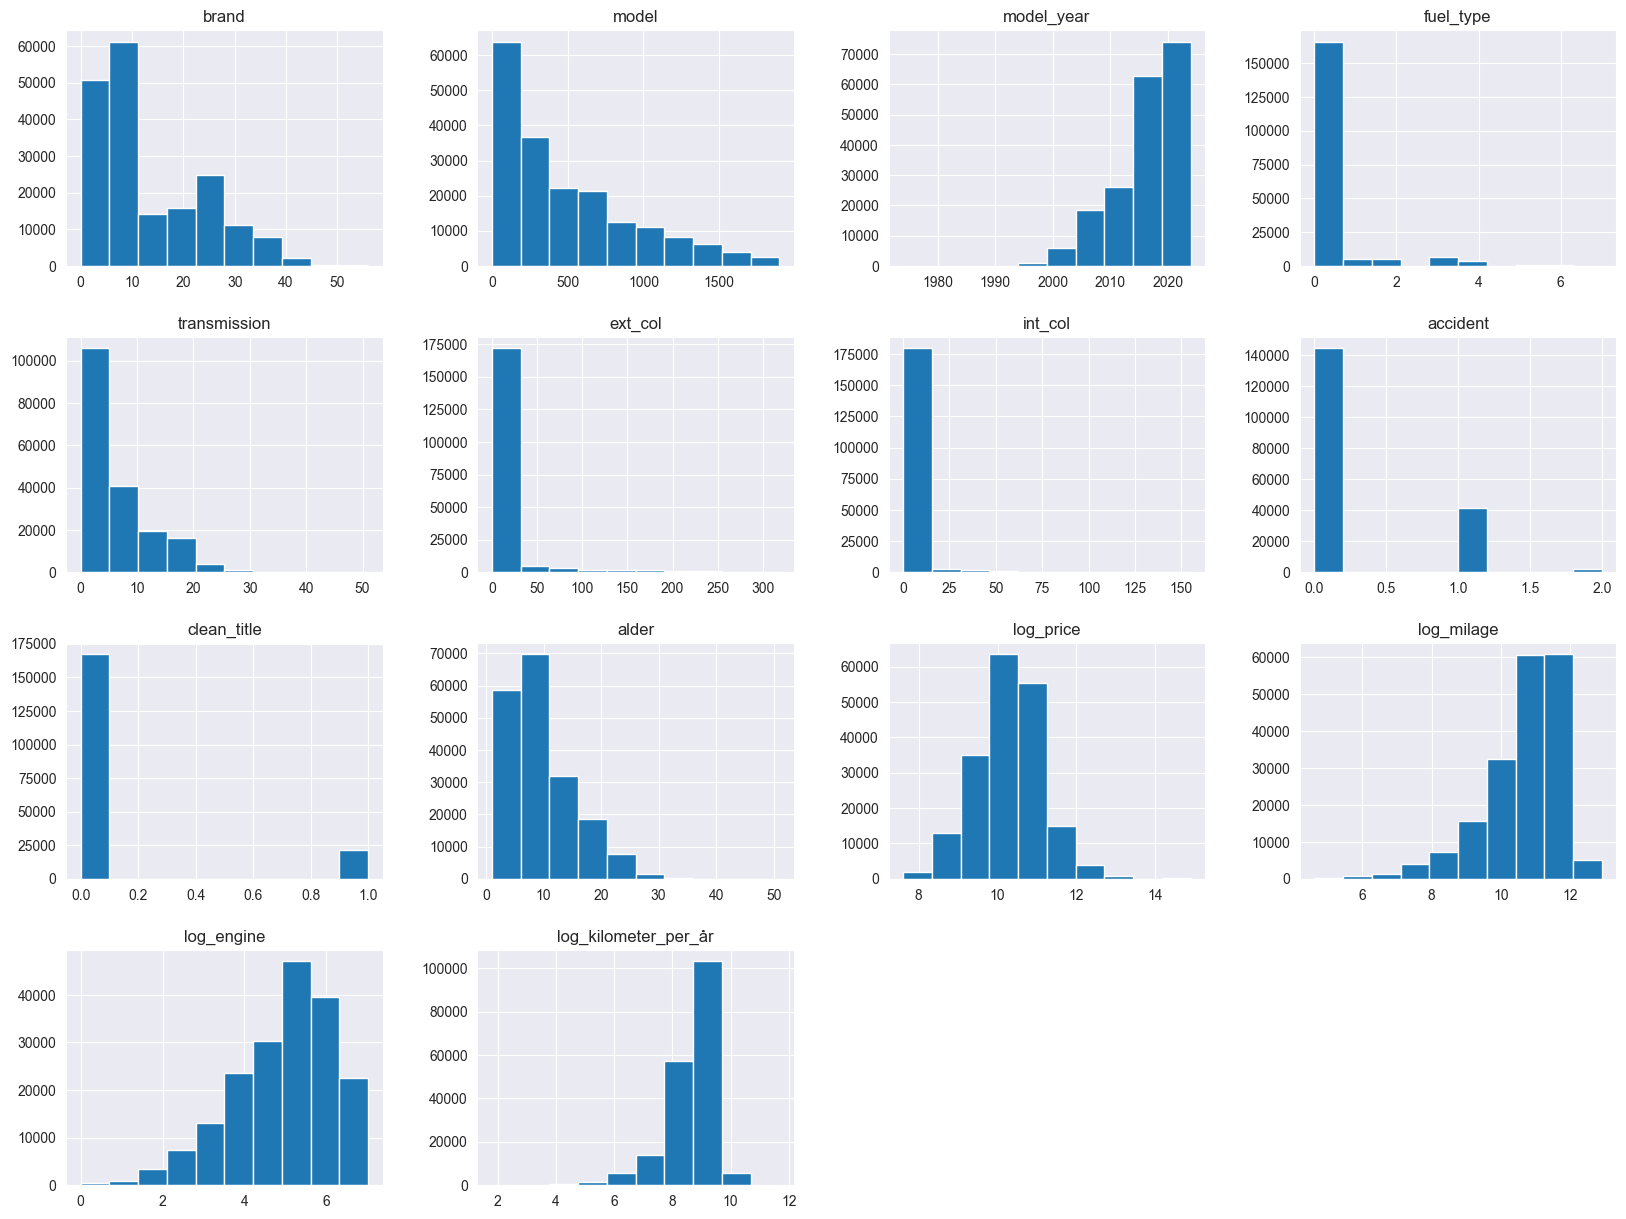

In [104]:
train_data['log_price'] = np.log1p(train_data['price'])
train_data['log_milage'] = np.log1p(train_data['milage'])
train_data['log_engine'] = np.log1p(train_data['engine'])
train_data['log_kilometer_per_år'] = np.log1p(train_data['kilometer_per_år'])

# Drop originalene etter å ta en log-transformasjon
train_data = train_data.drop(['price', 'milage', 'engine', 'kilometer_per_år'], axis=1)

train_data.hist(figsize=(20, 15))

Vi bytter ut de enkelte kategoriene med en mer fordelt verson av de. Vi tror og håper det å redusere skjevheten forbedrer modellens ytelse. Vi kan gå tilbake til å predikere "price" når vi skal sammenligne med fasiten, men bruker dette kun for å trene modellen.

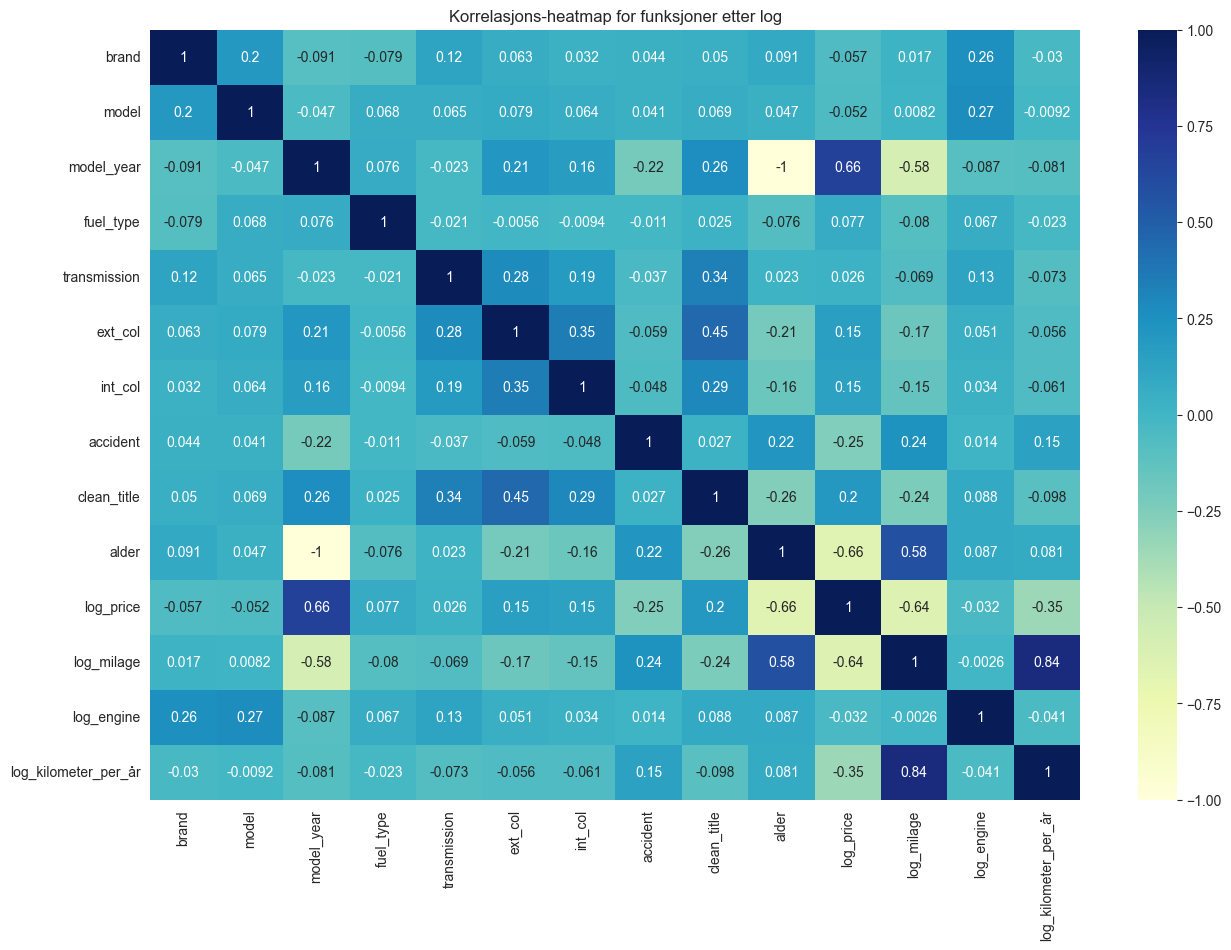

In [105]:
plt.figure(figsize=(15, 10))
sns.heatmap(train_data.corr(), annot=True, cmap="YlGnBu")
plt.title("Korrelasjons-heatmap for funksjoner etter log")
plt.show()

Vi ser at korrelasjonene har forandret seg i ganske stor grad. Vi skal ikke se for mye på det nå, men enkelte deler gir mening. For eksempel så har "model_year" mye større påvirkning nå enn før

In [107]:
train_set, test_set = train_test_split(train_data, test_size=0.25, random_state=42)
X_train = train_set.drop("log_price", axis=1)
y_train = train_set["log_price"]
X_test = test_set.drop("log_price", axis=1)
y_test = test_set["log_price"]


Setter opp preprocesseringspipeling som sikrer at vi håndterer manglende verdier i de numeriske funksjonene. Vi har også satt "strategy" til 'mean'. Slik vi har forstått det er dette den mest vanlige måten, men så på et annet eksempel hvor de brukte 'median' og endte med bedre resultat. Noe vi kunne gått mer inn på hvis vi forstod hvorfor det gir bedre resultat.

In [108]:
# Definer preprocesseringspipeline for numeriske funksjoner
numeriske_egenskaper = ["log_milage", "alder", "log_kilometer_per_år"]
numerisk_transformator = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerisk_transformator, numeriske_egenskaper)
    ], remainder='passthrough'  # Behold de heltallskodede kategoriske kolonnene som de er
)


'from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(random_state=seed, n_jobs=-1)

from xgboost import XGBRegressor
model_XGBR = XGBRegressor(random_state=seed, n_jobs=-1)

from sklearn.ensemble import GradientBoostingRegressor
model_GBR = GradientBoostingRegressor()'
Bruker randomForest siden det ga best resultat når vi kjørte dette på verson 1 i vanlig python.


Valgte å gå for pipelines for å unngå transformation hvis vi hadde brukt fit(). Ettersom dette ble veldig ulesbart.

Andre goder ved pipeline: Kombinerer preprocessing og modelltrening. Kan husker "alt" og kan ".predict()" på ny data som  kommer inn uten at vi trenger å bruke hver preprocesseringstrinn.

In [110]:
# Modellfilnavn for lagring og lasting
modell_filnavn = 'bil_pris_predictor_modell.pkl'

# Slett eksisterende modellfil hvis den finnes
#if os.path.exists(modell_filnavn):
#    os.remove(modell_filnavn)
#    print("Gammel modellfil slettet.")

# Sjekk om modellen allerede er lagret
if os.path.exists(modell_filnavn):
    # Last inn modellen hvis den eksisterer
    rf_pipeline = joblib.load(modell_filnavn)
    print("Modell lastet inn fra fil.")
else:
# Opprett pipeline med RandomForestRegressor
    rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=250,
        max_depth=17,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ))
])

# Tren modellen på hele treningssettet
rf_pipeline.fit(X_train, y_train)

# Lagre den trente modellen for å unngå ny trening i fremtiden
joblib.dump(rf_pipeline, modell_filnavn)
print("Modell trent og lagret til fil.")


Gammel modellfil slettet.
Modell trent og lagret til fil.


In [111]:

# Predict on test data
test_set['log_price_pred'] = rf_pipeline.predict(X_test)
test_set['price_pred'] = np.expm1(test_set['log_price_pred'])  # Convert predictions back to original scale
test_set['price'] = np.expm1(y_test)  # Convert true log prices back to original scale

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_set['price'], test_set['price_pred']))
print("Root Mean Squared Error (RMSE) on test set:", rmse)


Root Mean Squared Error (RMSE) on test set: 66401.909924559


In [112]:
# Display head of the test set with predictions
print(test_set[['price', 'price_pred']].head())

          price    price_pred
111355  37999.0  38467.049392
182258  30000.0  16936.725247
14147   26772.0  34941.358424
79313   24999.0  21519.211044
101160  47995.0  35334.981005
